# ExxWks-Demo

In diesem Notebook wird in einem minimalen Beispiel demonstriert, wie ein einfaches neuronales Netz zur Objekterkennung mit fast.ai erstellt und trainiert werden kann.
Konkret bauen wir einen Klassifikator, der auf Bildern von Objekten trainiert wird, und diese dann unterscheiden kann.

## Trainingsdaten bereitstellen

Zuerst müssen Trainingsdaten gesammelt und zur Verwendung in diesem Beispiel hochgeladen werden. Als Rohdaten können z.b. mit dem Smartphone aufgenommene Bilder von Objekten dienen.
In diesem Beispiel wird ein Netz verwendet, das mit sehr wenig neuen Trainingsdaten Ergebnisse erzielen kann, da es bereits vortrainiert ist und spezielle Techniken (Transfer Learning)
verwendet werden. Pro Klasse reichen hier ungefähr 25 Bilder aus. Für diese Demo reichen die Datensets, die im geklonten Repository enthalten sind. 

Alternativ können auch eigenen Bilder hochgeladen werden:

Zunächst müssen im JupyterLab neue Ordner für die Bilder angelegt werden, z.b. im Verzeichnis dieses Notebooks unter "/datasets/". Der Name des letzten Ordners in der Hierarchie, in den im nächsten Schritt jeweils die Bilder hochgeladen werden, legt standardmäßig den Namen der Klasse fest.
Nachdem wir einen der neu angelegten Ordner geöffnet haben, können über den "Upload Files" Button (über der Ordneransicht) die Bilder der jeweiligen Klasse auf dem lokalen Rechner ausgewählt
und hochgeladen werden. (Es können mehrere Bilder auf einmal ausgewählt werden; je nach Dateigröße kann der Upload eine Weile dauern.)
Sobald alle Bilder in den richtigen Ordnern liegen, ist dieser Schritt abgeschlossen.

Nun muss das Notebook konfiguriert werden und die benötigten fast.ai Packages importiert werden:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

Pfad zu den Bilderordnern angeben und überprüfen:

In [2]:
path = Path('datasets/tableware')
path.ls()

[PosixPath('datasets/tableware/mug'),
 PosixPath('datasets/tableware/bowl'),
 PosixPath('datasets/tableware/glass')]

Die Bilddaten können nun für das Training geladen und transformiert werden. Danach lassen wir uns eine zufällige Auswahl anzeigen:

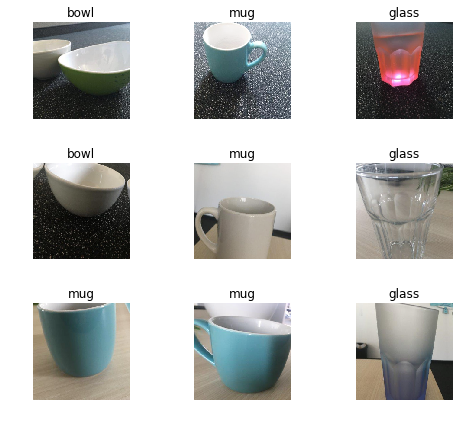

In [3]:
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))

Die Klassenlabels können nun ebenfalls geprüft werden:

In [4]:
print(data.classes)

['bowl', 'glass', 'mug']


Wenn alles funktioniert hat, stehen uns jetzt die Trainingsdaten für das Netz zur Verfügung.

## Neuronales Netz konfigurieren und trainieren

Für dieses Beispiel verwenden wir eine Variante eines klassischen Convolutional Neural Networks (CNN) für die Bilderkennung, das ResNet-34. Wir können uns außerdem die Architektur
des Netzwerks ausgeben lassen, die Details sind für die Zwecke dieser Demo aber erst einmal nicht relevant.

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Nun wird das eigentliche Training gestartet und die resultierenden Gewichte gespeichert:

In [7]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.394688,0.517756,0.200000,00:03
1,0.768210,0.080890,0.000000,00:00
2,0.536652,0.034264,0.000000,00:00
3,0.392041,0.036972,0.000000,00:00


## Trainingsergebnisse

Als gute Übersicht für die Trainingsergebnisse dient die Confusion Matrix. Diese stellt die Ergebnisse auf dem Testdatensatz dar, der beim Konfigurieren miterstellt wurde.
In der Confusion Matrix können wir ablesen, als welche Klasse die Bilder erkannt wurden. Auf der y-Achse sind hierbei die tatsächlichen Klassen der Bilder mit "Actual" eingetragen,
in der Literatur oft als Ground-truth bezeichnet, auf der x-Achse die Klassifikationen des Netzes:

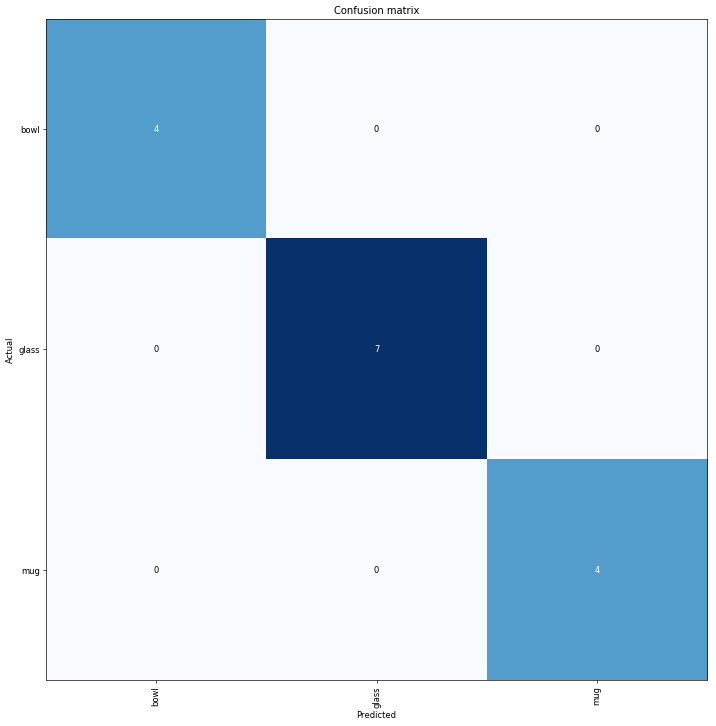

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Zum Beispiel würde in der Matrix eine "2" im Quadranten rechts oben bedeuten, dass 2 Fehlerkennungen vorliegen. Die Diagonalachse von links oben
nach rechts unten zeigt die richtigen Klassifikationen an. Da die aktuelle Aufgabe für das Netzwerk sehr einfach ist, sollten keine Fehlerkennungen vorliegen. Zusätzlich können wir uns 
die Bilder anzeigen lassen, bei denen sich das Netz am unsichersten war:

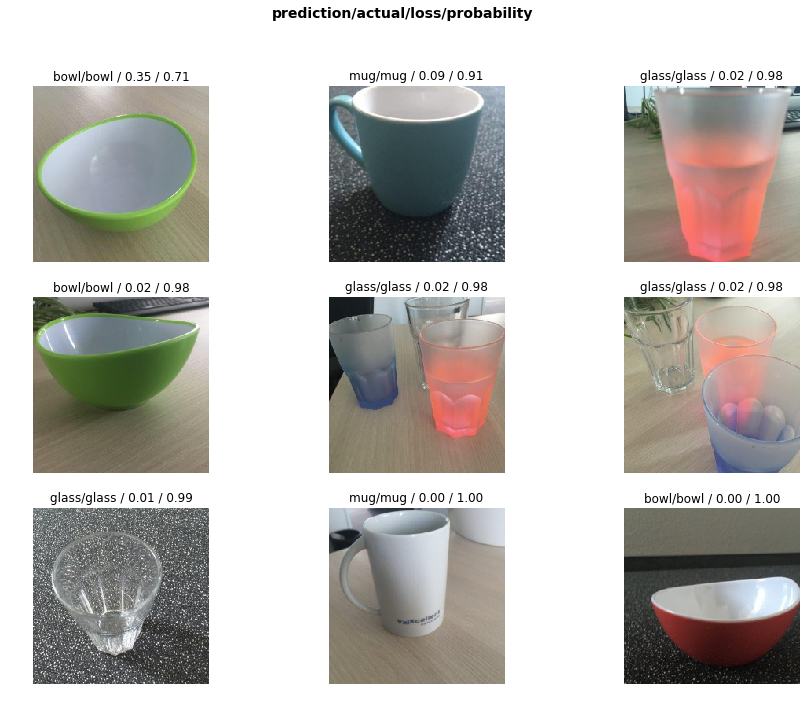

In [10]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Setzen wir den Parameter heatmap auf "True", können wir uns die Bereiche der Bilder anzeigen lassen, die für die Klassifikation ausschlaggebend waren:

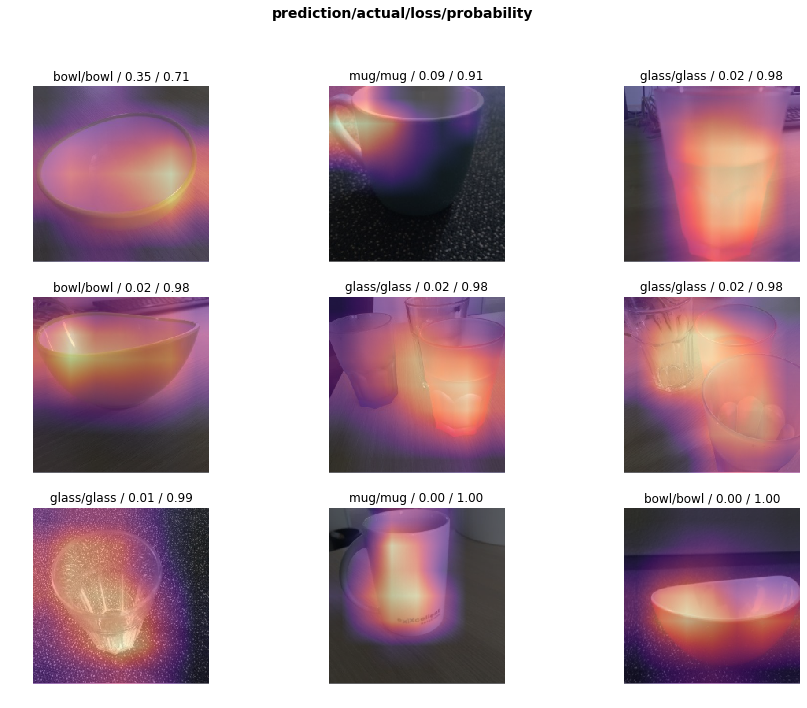

In [11]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

## Trainiertes Netz anwenden

Das trainierte Netz kann jetzt genutzt werden, um andere Bilder zu klassifizieren. Im Folgenden wird es zunächst gespeichert, und dann die Berechnung auf der Grafikkarte konfiguriert:

In [12]:
learn.export()
defaults.device = torch.device('cpu')
learn = load_learner(path)

Jetzt das Bild laden und anzeigen:

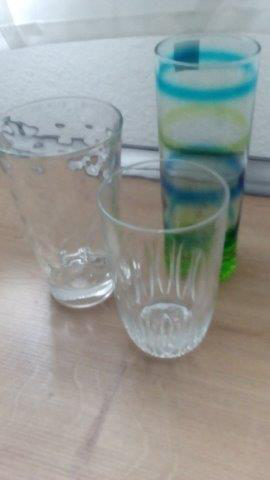

In [14]:
img = open_image('datasets/inference/glass_foreign7.jpg')
img

Und schließlich wird das Bild an das Netz übergeben und klassifiziert:

In [15]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category glass